In [17]:
from datasets import load_dataset,load_dataset_builder
import torch
import torchvision.transforms.functional as TF
from miniai.datasets import *

x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b['image'] = [(torch.flatten(TF.to_tensor(o)).view(-1, 28, 28) - 0.29) / 0.35 for o in b['image']]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

Found cached dataset fashion_mnist (/home/admin/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), tensor([2, 8, 7, 6, 9, 5, 3, 5, 8, 3]))

In [19]:
xb.mean(), xb.std()

(tensor(-0.0249), tensor(1.0022))

In [20]:
from miniai.conv import conv
from torch import nn

import torch
import numpy as np

def get_model():
    layers = [conv(1,8),            #14x14
    conv(8,16),            #7x7
    conv(16,32),           #4x4
    conv(32,64),           #2x2
    conv(64,10, act=False), #1x1
    nn.Flatten()]
    model = nn.Sequential(*layers)
    return model

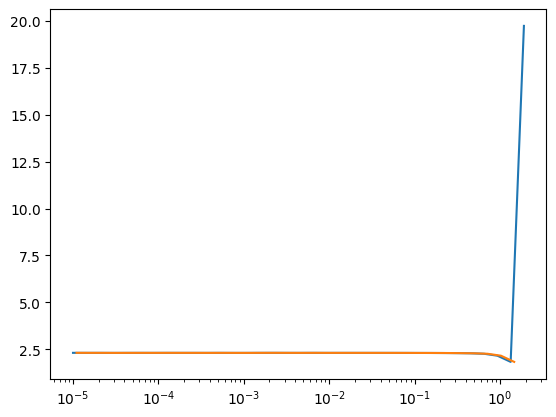

In [21]:
import miniai
from miniai.learner import MomentumLearner as Learner, DeviceCB, MetricsCB, ProgressCB, LRFinderCB
import torch.nn.functional as F
from torcheval.metrics import MulticlassAccuracy,Mean

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), LRFinderCB(gamma=1.1), metrics, ProgressCB(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.lr_find()

accuracy,loss,epoch,train
0.324,1.855,0,train
0.725,0.750,0,eval


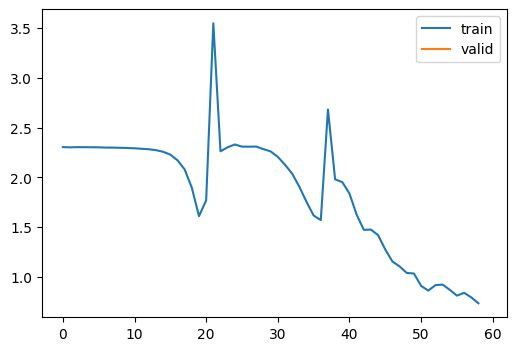

In [22]:
from miniai.activations import ActivationStats
import fastcore.all as fc

metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), visual]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2,cbs=cbs)
learn.fit(1)

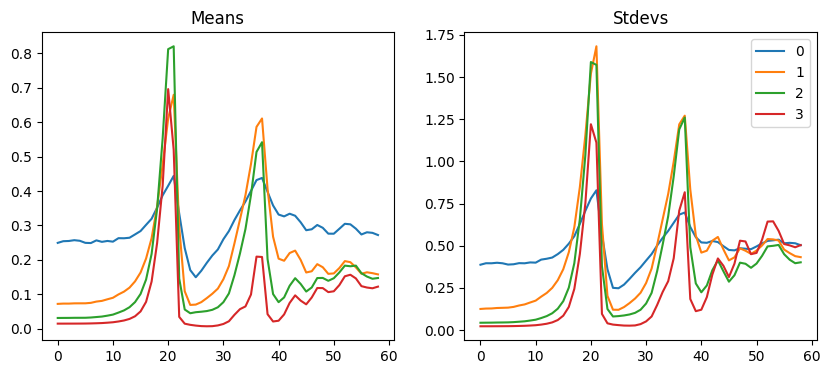

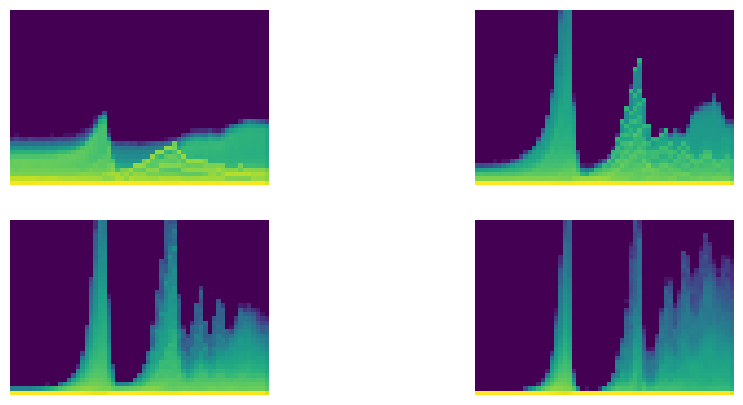

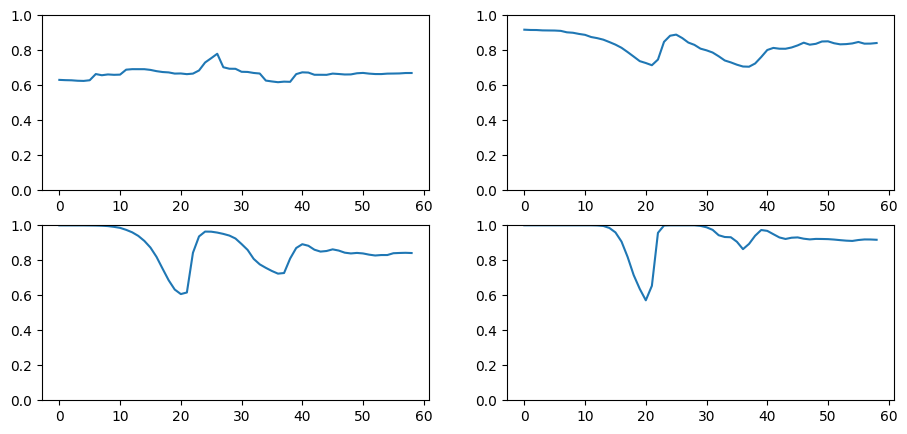

In [23]:
visual.plot_stats()

visual.color_dim()

visual.dead_chart()

In [24]:
xb.mean(), xb.std()

(tensor(-0.0249), tensor(1.0022))

In [66]:
def init_weights(m, leak=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(m.weight, a = leak)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

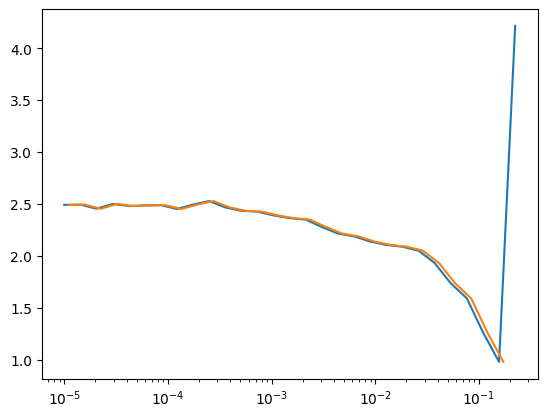

In [26]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(nn.Conv2d))
model = get_model()
model.apply(init_weights)
cbs = [DeviceCB(), LRFinderCB(gamma=1.1), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=1e-2, cbs=cbs)
learn.lr_find()

accuracy,loss,epoch,train
0.676,0.965,0,train
0.818,0.483,0,eval
0.849,0.417,1,train
0.842,0.439,1,eval
0.866,0.369,2,train
0.861,0.386,2,eval


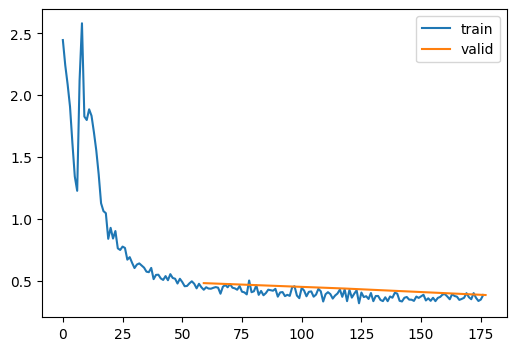

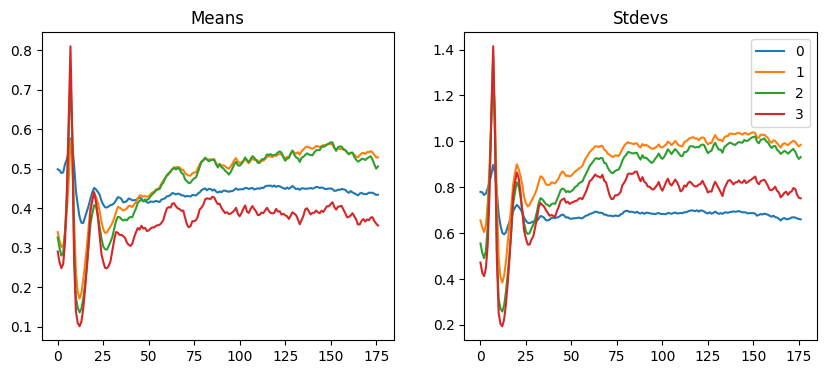

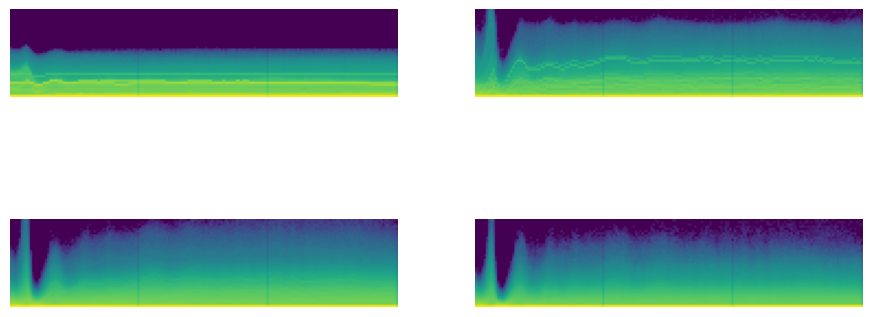

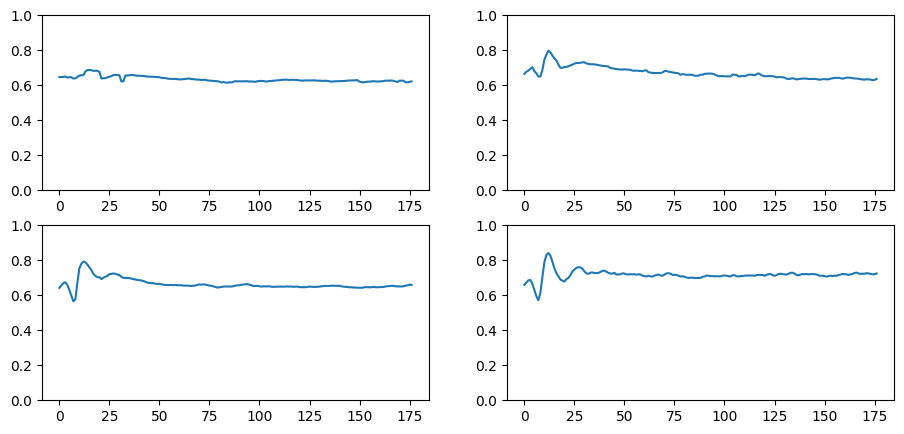

In [45]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(nn.ReLU))
model = get_model()
model.apply(init_weights)
cbs = [DeviceCB(), visual, metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(3)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()

In [61]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=0.1, sub=0.5, maxv=2):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def conv2(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, GeneralRelu())
    return res

def get_model_v2():
    layers = [conv2(1,8),            #14x14
    conv2(8,16),            #7x7
    conv2(16,32),           #4x4
    conv2(32,64),           #2x2
    conv2(64,10, act=False), #1x1
    nn.Flatten()]
    model = nn.Sequential(*layers)
    return model

In [64]:
import matplotlib.pyplot as plt
def plot_func(f):
    x = torch.arange(-2, 2, 0.01)
    y = f(x)
    plt.grid(True, which='both', ls='--')
    plt.plot(x,y)
    
# plot_func(GeneralRelu())

accuracy,loss,epoch,train
0.761,0.674,0,train
0.837,0.447,0,eval
0.859,0.392,1,train
0.858,0.388,1,eval
0.875,0.347,2,train
0.865,0.379,2,eval


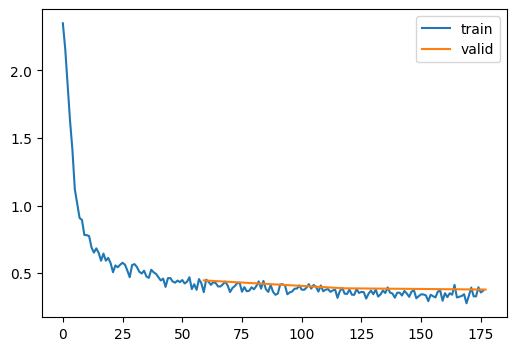

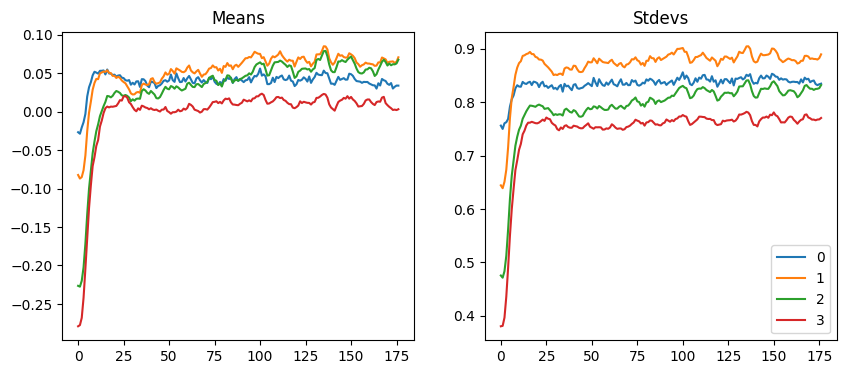

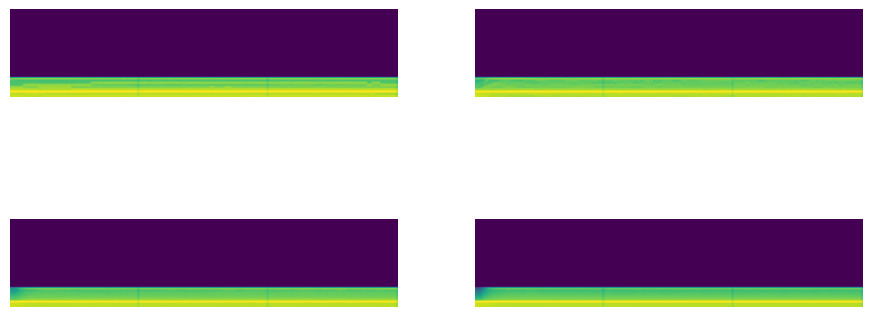

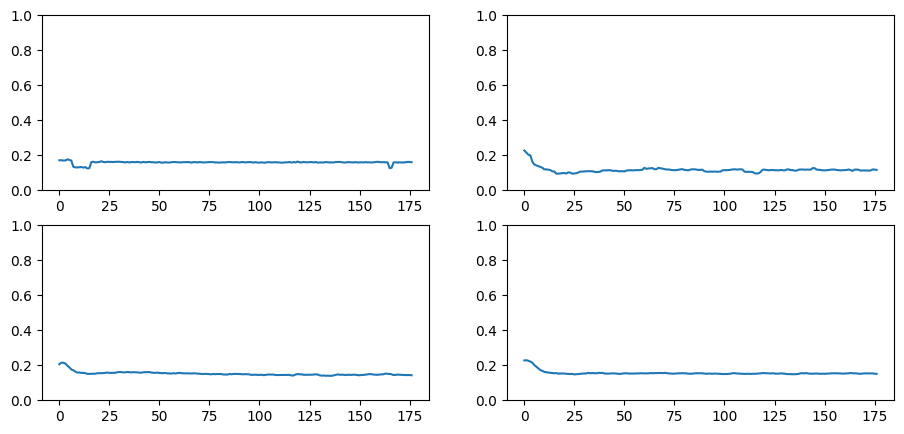

In [68]:
from functools import partial
metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(GeneralRelu))
model = get_model_v2()
model.apply(partial(init_weights, leak=0.1))
cbs = [DeviceCB(), metrics, visual, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(3)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()

accuracy,loss,epoch,train
0.886,0.315,0,train
0.871,0.355,0,eval
0.889,0.309,1,train
0.873,0.352,1,eval


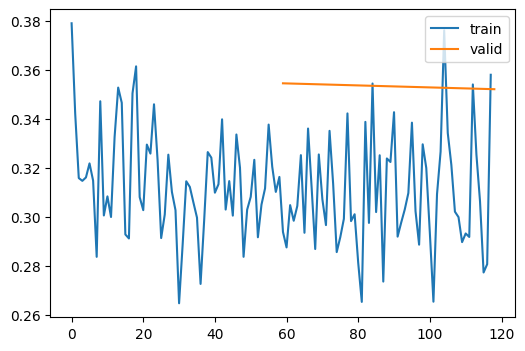

In [69]:
learn = Learner(model, dls, F.cross_entropy, lr=0.01, cbs=cbs)
learn.fit(2)